In [ ]:
Code to generate various confidence bands and find the best one 
by comparing the sums of the lengths of confidence

In [14]:
import numpy as np
import math
import matplotlib.pyplot as plt
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.callbacks import TensorBoard
from time import time
import itertools
from math import factorial

In [16]:
# Generate X and Y pairs where dim of X = (1, look_back)
def create_dataset(dataset, look_back = 1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, :])
    return np.array(dataX), np.array(dataY)

In [17]:
# Arrange blocks of data according to permutation
def generateData(data, perm):
    n = data.shape[0]
    blockSize = n // len(perm)
    dataSet = np.zeros(data[0].shape)
    for i in perm:
        block = data[i*blockSize:(i+1)*blockSize]
        dataSet = np.vstack((dataSet, block))
    dataSet = dataSet[1:]
    return dataSet

In [18]:
fields = ['open', 'close']
dataframe = read_csv('GOOGL_data.csv', skipinitialspace = True, squeeze = True, usecols = fields)

print(dataframe.head())
data = np.array(dataframe)
print(data.shape)

       open     close
0  390.4551  393.0777
1  389.5892  391.6012
2  391.2659  390.7403
3  390.4551  391.8214
4  390.2549  394.3039
(1259, 2)


In [19]:
# Scale between (0, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)
print(data[:5])

[[0.00683718 0.01210825]
 [0.0057589  0.01027231]
 [0.00784685 0.00920184]
 [0.00683718 0.01054612]
 [0.00658788 0.01363296]]


In [20]:
split = 0.72
trainSize = int(len(data)*split)
testSize = len(data)-trainSize
print(trainSize)
print(testSize)

906
353


In [21]:
numInterval = 3
blockSize = trainSize//numInterval
print(blockSize)

302


In [22]:
train = data[0:trainSize,:]
test = data[trainSize:len(data),:]
print(train[:5])

[[0.00683718 0.01210825]
 [0.0057589  0.01027231]
 [0.00784685 0.00920184]
 [0.00683718 0.01054612]
 [0.00658788 0.01363296]]


Count =  0
Epoch 1/10
902/902 [==============================] - 9s 9ms/step - loss: 0.0011
Epoch 2/10
902/902 [==============================] - 8s 9ms/step - loss: 3.4872e-04
Epoch 3/10
902/902 [==============================] - 8s 9ms/step - loss: 3.0338e-04
Epoch 4/10
902/902 [==============================] - 8s 9ms/step - loss: 2.4706e-04
Epoch 5/10
902/902 [==============================] - 8s 9ms/step - loss: 2.0594e-04
Epoch 6/10
902/902 [==============================] - 8s 9ms/step - loss: 1.8750e-04
Epoch 7/10
902/902 [==============================] - 8s 9ms/step - loss: 1.6567e-04
Epoch 8/10
902/902 [==============================] - 8s 9ms/step - loss: 1.4735e-04
Epoch 9/10
902/902 [==============================] - 8s 9ms/step - loss: 1.4396e-04
Epoch 10/10
902/902 [==============================] - 8s 9ms/step - loss: 1.3999e-04
Train Score: 8.47 RMSE
Test Score: 11.37 RMSE
Count =  1
Epoch 1/10
902/902 [==============================] - 9s 10ms/step - loss: 0.0013
Epo

Text(0.5,1,'Epoch = 10 Train = 14.39 Test = 21.35')

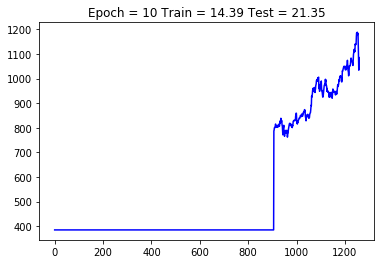

In [23]:
# Generate all permutations of the series 0, 1, 2, ... numInterval
permutations = itertools.permutations(range(numInterval))
testBand = []

count = 0
for perm in permutations:
    print("Count = ", count)
    count += 1
    trainSet = generateData(train, perm)
    trainSet = np.reshape(trainSet, trainSet.shape)
    shuffleData = np.vstack((trainSet, test))

    lookBack = 3
    trainX, trainY = create_dataset(trainSet, lookBack)
    testX, testY = create_dataset(test, lookBack)

    # trainX = np.reshape(trainX, (trainX.shape[0], 2, trainX.shape[1]))
    # testX = np.reshape(testX, (testX.shape[0], 2, testX.shape[1]))

    units = 100
    drop = 0.2
    epoch = 10

    model = Sequential()
    model.add(LSTM(units, input_shape=(lookBack, 2)))
    model.add(Dense(2))
    model.compile(loss='mean_squared_error', optimizer='nadam')
#     Tensorboard
#     model.summary()
#     tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
#     model.fit(trainX, trainY, epochs=epoch, batch_size=1, verbose=1, callbacks=[tensorboard])
    model.fit(trainX, trainY, epochs=epoch, batch_size=1, verbose=1)

    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

#     Inverse the scaling
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform(trainY)
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform(testY)

#     RMSE score
    trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(testY, testPredict))
    print('Test Score: %.2f RMSE' % (testScore))

#     Plot training data
    trainPredictPlot = np.empty_like(shuffleData)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[lookBack:len(trainPredict)+lookBack, :] = trainPredict
    
#     Plot test data
    testPredictPlot = np.empty_like(shuffleData)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+(lookBack*2)+1:len(data)-1, :] = testPredict
    
#     Append results to calculate the test band
    testBand.append(testPredict)

    col = 0
    testPlot = np.empty_like(trainSet)
    testPlot[:, :] = 0
    testPlot = np.vstack((testPlot, test))
#     plt.plot(scaler.inverse_transform(shuffleData)[:,col])
#     plt.plot(trainPredictPlot[:,col], color = 'orange')
#     plt.plot(testPredictPlot[:,col], color = 'green')
plt.plot(scaler.inverse_transform(testPlot)[:,col], color = 'blue')
plt.title('Epoch = %d Train = %.2f Test = %.2f' % (epoch, trainScore, testScore))

In [26]:
testBand = np.array(testBand)
testBand = np.reshape(testBand, (testBand.shape))

In [27]:
testBand.shape

(6, 349, 2)

In [28]:
print(np.mean(testBand[:,0,:], axis = 0))
print(np.std(testBand[:,0,:], axis = 0))

[796.89166 796.4277 ]
[5.1891274 7.460066 ]


In [29]:
z_alpha = 1.96
n = factorial(numInterval)

confInterval = []

# Calculate the 95% confidence interval for each time step
for i in range(testBand.shape[1]):
    X = testBand[:, i, :]
    xBar = np.mean(X, axis = 0)
    s = np.std(X, axis = 0)
    l = xBar - 1.96*s/(n**0,.5)
    r = xBar + 1.96*s/(n**0,.5)
    pair = [l, r]
    confInterval.append(pair)

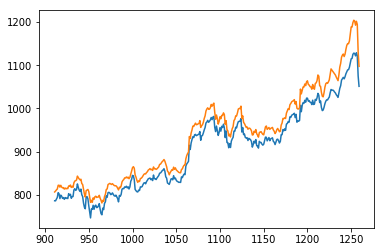

In [30]:
col = 0
offset = len(trainPredict)+(lookBack*2)+2
lower = []
upper = []

# Get upper and lower bounds
for i in range(len(confInterval)):
    lower.append(confInterval[i][0][0])
    upper.append(confInterval[i][1][0])

XLower = np.array(range(offset+1, offset+1+testBand.shape[1]))
XUpper = np.array(range(offset+1, offset+1+testBand.shape[1]))
plt.plot(XLower, lower)
plt.plot(XUpper, upper)
plt.show()

In [34]:
lower

[786.7209730148315,
 786.5355787277222,
 790.684811592102,
 794.353982925415,
 805.4519691467285,
 802.9142274856567,
 791.6535024642944,
 799.7313785552979,
 797.2541036605835,
 792.2819995880127,
 794.1569299697876,
 790.0669412612915,
 794.1683206558228,
 791.9733953475952,
 793.5473012924194,
 791.6955261230469,
 803.1496992111206,
 798.8361339569092,
 801.663290977478,
 792.4390068054199,
 796.1277132034302,
 796.5345468521118,
 811.5511331558228,
 814.7087755203247,
 810.7269420623779,
 812.5019302368164,
 825.6331253051758,
 817.8399019241333,
 811.4324102401733,
 808.37864112854,
 813.6017217636108,
 800.7171821594238,
 796.4581623077393,
 781.251519203186,
 771.8124008178711,
 768.2297048568726,
 795.2344117164612,
 796.367648601532,
 791.4115314483643,
 775.2487678527832,
 761.3875942230225,
 747.0841941833496,
 767.7099666595459,
 766.7739582061768,
 776.3069744110107,
 766.923731803894,
 774.7214488983154,
 776.6392269134521,
 770.9768924713135,
 771.6094961166382,
 774.696

In [38]:
# Sum of the lengths of the confidence intervals at each time point.
sumIntervals = np.sum(np.array(upper) - np.array(lower))

In [39]:
sumIntervals

9913.112132072449

In [42]:
# Length of maximum interval
maxInterval = np.max(np.array(upper) - np.array(lower))

In [43]:
maxInterval

76.03897857666016